In [1]:
import sys
import os

# the path that contains SFCN codes
SFCN_path = "../UKBiobank_deep_pretrain-master"
sys.path.append(SFCN_path)

In [80]:
from dp_model.model_files.sfcn import SFCN
from dp_model import dp_loss as dpl
from dp_model import dp_utils as dpu

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import lstsq
import nibabel as nib
from nilearn import plotting
from tqdm import tqdm

# Obtain Data Info

In [3]:
data_info_df = pd.read_csv("./data/T1_MNI_20252_2_0.csv")

print(f"max age: {data_info_df['f.21003.2.0'].max()}, min age: {data_info_df['f.21003.2.0'].min()},")

max age: 82.0, min age: 44.0,


## HC

In [4]:
HC_info_df = data_info_df[(data_info_df["status"]=="HC") & (data_info_df["path"].notna())]
HC_info_df.set_index("f.eid", inplace=True)
HC_info_df

,f.21003.2.0,f.20126.0.0,f.2976.2.0,status,path,MNI
f.eid,,,,,,
1198929,70.0,0.0,NaN,HC,./data/T1_MNI_20252_2_0/HC/1198929/T1/T1_brain...,True
3030287,60.0,0.0,NaN,HC,./data/T1_MNI_20252_2_0/HC/3030287/T1/T1_brain...,True
3055051,71.0,0.0,NaN,HC,./data/T1_MNI_20252_2_0/HC/3055051/T1/T1_brain...,True
2828573,59.0,0.0,NaN,HC,./data/T1_MNI_20252_2_0/HC/2828573/T1/T1_brain...,True
2507464,70.0,0.0,NaN,HC,./data/T1_MNI_20252_2_0/HC/2507464/T1/T1_brain...,True
...,...,...,...,...,...,...
2035535,53.0,0.0,NaN,HC,./data/T1_MNI_20252_2_0/HC/2035535/T1/T1_brain...,True
2288898,59.0,0.0,NaN,HC,./data/T1_MNI_20252_2_0/HC/2288898/T1/T1_brain...,True
3161207,68.0,0.0,NaN,HC,./data/T1_MNI_20252_2_0/HC/3161207/T1/T1_brain...,True


## MDD

In [5]:
MDD_info_df = data_info_df[(data_info_df["status"]=="mdd") & (data_info_df["path"].notna())]
MDD_info_df.set_index("f.eid", inplace=True)
MDD_info_df

,f.21003.2.0,f.20126.0.0,f.2976.2.0,status,path,MNI
f.eid,,,,,,
3303915,72.0,5.0,NaN,mdd,./data/T1_MNI_20252_2_0/mdd/3303915/T1/T1_brai...,True
3111573,69.0,4.0,NaN,mdd,./data/T1_MNI_20252_2_0/mdd/3111573/T1/T1_brai...,True
2688028,60.0,4.0,NaN,mdd,./data/T1_MNI_20252_2_0/mdd/2688028/T1/T1_brai...,True
2330198,63.0,5.0,NaN,mdd,./data/T1_MNI_20252_2_0/mdd/2330198/T1/T1_brai...,True
1244402,77.0,4.0,NaN,mdd,./data/T1_MNI_20252_2_0/mdd/1244402/T1/T1_brai...,True
...,...,...,...,...,...,...
1242643,70.0,4.0,NaN,mdd,./data/T1_MNI_20252_2_0/mdd/1242643/T1/T1_brai...,True
3200432,69.0,5.0,NaN,mdd,./data/T1_MNI_20252_2_0/mdd/3200432/T1/T1_brai...,True
4208029,62.0,4.0,NaN,mdd,./data/T1_MNI_20252_2_0/mdd/4208029/T1/T1_brai...,True


## Peek at one sample

In [40]:
img_path = HC_info_df.loc[1198929]["path"]
img = nib.load(img_path) ## nifti file
print(type(img))

<class 'nibabel.nifti1.Nifti1Image'>


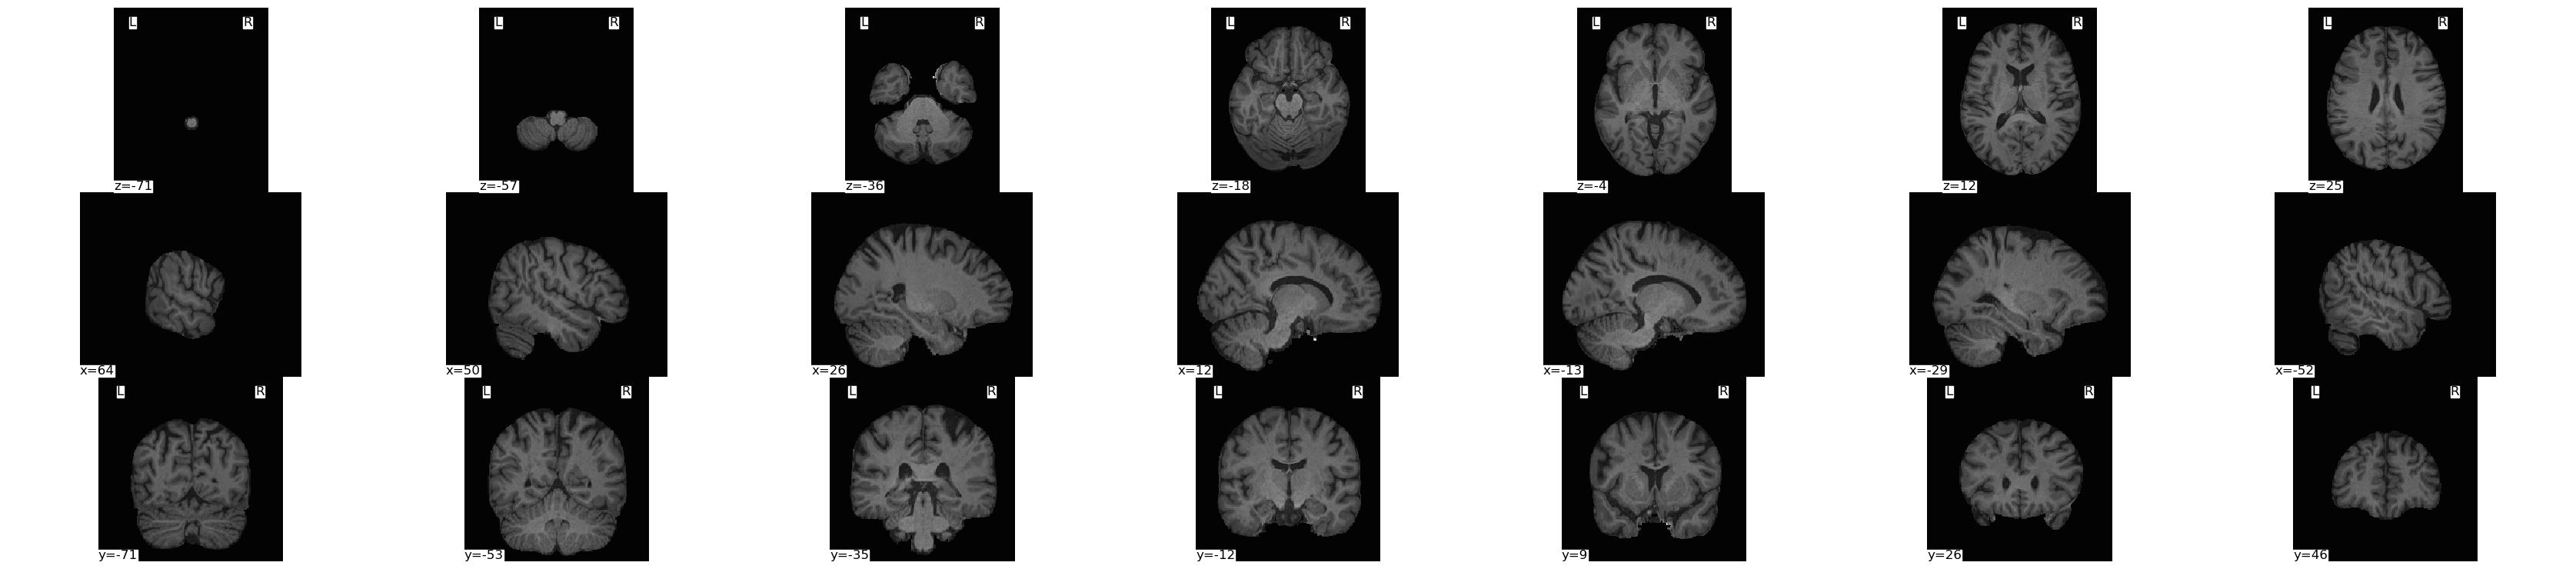

In [36]:
plotting.plot_img(img, display_mode='mosaic', cmap='gray')
plt.show()

In [38]:
img_raw_arr = img.get_fdata()
print(type(img_raw_arr))
print(img_raw_arr.shape)
print(f"max: {img_raw_arr.max()}, min: {img_raw_arr.min()}, avg: {img_raw_arr.mean()}")

<class 'nibabel.nifti1.Nifti1Image'>
<class 'numpy.ndarray'>
(182, 218, 182)
max: 3006.0, min: -45.0, avg: 223.49294020577668


In [39]:
# Preprocessing
img_arr_0 = img_raw_arr/img_raw_arr.mean()
img_arr = dpu.crop_center(img_arr_0, (160, 192, 160))
print(img_arr.shape)
print(f"max: {img_arr.max()}, min: {img_arr.min()}, avg: {img_arr.mean()}")

(160, 192, 160)
max: 13.450089283501686, min: -0.20134864196858812, avg: 1.465215652475866


# Create Dataset

## Help Functions

In [41]:
def obtain_arr_from_nii(path):
    """
    extract + crop
    """
    # extract nii object
    img = nib.load(path)
    # extract raw arr data
    img_raw_arr = img.get_fdata()
    # preprocess
    img_arr_0 = img_raw_arr/img_raw_arr.mean()
    img_arr = dpu.crop_center(img_arr_0, (160, 192, 160)) # crop
    return img_arr

In [44]:
def create_dataset_from_nii_path_list(path_list):
    """
    extract array of nii image from path_list, 
    crop,
    return np array of shap (n_samples, 1, 160, 192, 160)
    """
    arr_list = []

    for path in tqdm(path_list):
    #for path in HC_path_list:
        # get image array data
        img_arr = obtain_arr_from_nii(path) # (160, 192, 160)
    
        # reshape -- add batch size, channel size
        sp = (1,1) + img_arr.shape 
        img_arr_reshape = img_arr.reshape(sp) # (1, 1, 160, 192, 160)
        
        arr_list.append(img_arr_reshape)
    
    data_arr = np.vstack(arr_list)
    return data_arr

## HC dataset

**The order of scan is the same as the order in `HC_info_df`**

In [46]:
HC_path_list = HC_info_df["path"].tolist()
HC_count = len(HC_path_list)
HC_count

300

In [47]:
HC_data_arr = create_dataset_from_nii_path_list(HC_path_list)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:13<00:00,  4.10it/s]


In [49]:
print((HC_data_arr[0] == HC_data_arr[7]).all())

False


### save & load

300 is too much to store, no space disk available

100 --> 3.7G

In [50]:
HC_num = 100 # should <= HC_count
HC_dataset_path = f"./data/T1_MNI_20252_2_0/HC_data_{HC_num}.npy"

In [51]:
with open(HC_dataset_path, 'wb') as f:
    np.save(f, HC_data_arr[:HC_num])

In [52]:
with open(HC_dataset_path, 'rb') as f:
    HC_data_arr = np.load(f)

In [53]:
print(HC_data_arr.shape)
print(HC_data_arr.min())
print(HC_data_arr.max())
print(HC_data_arr.mean())

(100, 1, 160, 192, 160)
-0.667453366575311
18.35960267364449
1.465289658461411


## MDD dataset

**The order of scans is the same with the order recorded in `MDD_info_df`**

In [54]:
MDD_path_list = MDD_info_df["path"].tolist()
MDD_count = len(MDD_path_list)
MDD_count

100

In [55]:
MDD_data_arr = create_dataset_from_nii_path_list(MDD_path_list)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.42it/s]


In [56]:
print((MDD_arr_list[9]==MDD_arr_list[90]).all())

False


### save & load

In [57]:
MDD_num = 30 # should <= MDD_count
MDD_dataset_path = f"./data/T1_MNI_20252_2_0/MDD_data_{MDD_num}.npy"

In [58]:
with open(MDD_dataset_path, 'wb') as f:
    np.save(f, MDD_data_arr[:MDD_num])

In [59]:
with open(MDD_dataset_path, 'rb') as f:
    MDD_data_arr = np.load(f)

In [60]:
print(MDD_data_arr.shape)
print(MDD_data_arr.min())
print(MDD_data_arr.max())
print(MDD_data_arr.mean())

(30, 1, 160, 192, 160)
-0.38068427536307453
18.438912122192555
1.465260099194049


In [68]:
print((MDD_data_arr[0] == HC_data_arr[0]).all())

False


# Inference HC brain age

## Load the model

Model input shape: [batch_size, 1, 160, 192, 160]

In [11]:
model = SFCN()
model = torch.nn.DataParallel(model)
fp_ = os.path.join(SFCN_path, './brain_age/run_20190719_00_epoch_best_mae.p')
model.load_state_dict(torch.load(fp_))
model.cuda()

DataParallel(
  (module): SFCN(
    (feature_extractor): Sequential(
      (conv_0): Sequential(
        (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ReLU()
      )
      (conv_1): Sequential(
        (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ReLU()
      )
      (conv_2): Sequential(
        (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, 

## Get bin center

In [12]:
## a one-year age interval between 42 to 82 (for UK Biobank)
bin_center = np.arange(start=42.5, stop=82, step=1)
bin_center

array([42.5, 43.5, 44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5, 52.5,
       53.5, 54.5, 55.5, 56.5, 57.5, 58.5, 59.5, 60.5, 61.5, 62.5, 63.5,
       64.5, 65.5, 66.5, 67.5, 68.5, 69.5, 70.5, 71.5, 72.5, 73.5, 74.5,
       75.5, 76.5, 77.5, 78.5, 79.5, 80.5, 81.5])

## Help Functions

In [26]:
def inference_brain_age(data_loader, bin_center):
    age_pred_list = []

    for batch_ndx, samples in enumerate(data_loader):
        n_sample = samples.shape[0]
        samples = samples.type(torch.FloatTensor).cuda() ## double to float to cuda
    
        model.eval()
        with torch.no_grad():
            # a list of only one element: a tensor of size [samples.shape[0], 40, 1, 1, 1], in GPU
            output_list = model(samples)
    
        # to CPU and reshape to [samples.shape[0], 40]
        output_tensor =  output_list[0].cpu().reshape([n_sample, -1])
        output_arr = output_tensor.numpy()
    
        # exp: map from log domin to prob
        prob_dist = np.exp(output_arr) 
        prediction = prob_dist @ bin_center
    
        age_pred_list.extend(prediction)
        
    return age_pred_list

In [81]:
def bias_correction(y: np.ndarray, y_pred: np.ndarray):
    """
    :param y: chronological age (ground truth)
    :param y_pred: brain age before bias correction (predictions)
    :return: bias-corrected brain age
    """
    # Smith2019 bias correction
    linear_fit = LinearRegression(fit_intercept=True).fit(
        X=y, y=y_pred
    )
    intercept, slope = linear_fit.intercept_, linear_fit.coef_[0]
    y_pred_unbiased = (y_pred - intercept) / (slope + np.finfo(np.float32).eps) # avoid division by 0
    return y_pred_unbiased, intercept, slope

In [85]:
def plot_bias_correction_result(x, y, slope, intercept):
    """
    x: predicted age, np array
    y: chronological age, np array
    """
    slope = slope + np.finfo(np.float32).eps
    
    plt.plot(x, y, 'o', label='data')
    yy = np.linspace(40, 85, 200) # pred_unbiased
    xx = slope * yy + intercept # pred
    plt.plot(xx, yy, label=f"least squares fit, x = {slope} y + {intercept}")
    plt.xlabel('x: prediected age')
    plt.ylabel('y: chronological age')
    plt.legend(framealpha=1, shadow=True)
    plt.grid(alpha=0.25)
    plt.show()

## predict HC brain age

In [13]:
batch_size = 20
HC_loader = DataLoader(HC_data_arr, batch_size=batch_size, pin_memory=True)  ## NO shuffle

In [33]:
HC_age_pred_list = inference_brain_age(HC_loader, bin_center)

print(len(HC_age_pred_list))

100


In [76]:
HC_num = len(HC_age_pred_list)
HC_pred_df = HC_info_df.head(HC_num)[["f.21003.2.0"]]
HC_pred_df["age_pred"] = HC_age_pred_list
HC_pred_df

,f.21003.2.0,age_pred
f.eid,,
1198929,70.0,58.789781
3030287,60.0,56.418017
3055051,71.0,63.230960
2828573,59.0,55.169477
2507464,70.0,65.875464
...,...,...
4774918,73.0,62.963406
4740658,71.0,71.360154
4989289,71.0,65.919132


### Bias correction

In [77]:
# intercept and slope is for later use of MDD samples
HC_age_unbiased, intercept, slope = bias_correction(HC_pred_df["f.21003.2.0"].to_numpy().reshape(-1, 1), HC_pred_df["age_pred"].to_numpy().reshape(-1, 1))
HC_pred_df["age_unbiased"] = HC_age_unbiased
HC_pred_df

,f.21003.2.0,age_pred,age_unbiased
f.eid,,,
1198929,70.0,58.789781,62.698392
3030287,60.0,56.418017,59.305357
3055051,71.0,63.230960,69.051921
2828573,59.0,55.169477,57.519201
2507464,70.0,65.875464,72.835137
...,...,...,...
4774918,73.0,62.963406,68.669160
4740658,71.0,71.360154,80.681508
4989289,71.0,65.919132,72.897608


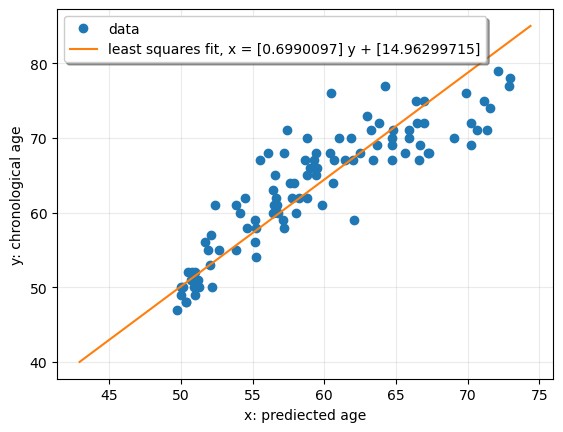

In [86]:
plot_bias_correction_result(HC_pred_df["age_pred"].to_numpy(), HC_pred_df["f.21003.2.0"].to_numpy(), slope, intercept)

### Save Results

In [89]:
# save prediction results
HC_pred_df.to_csv(f"./data/T1_MNI_20252_2_0/HC_pred_age_{HC_num}.csv")

## predict MDD brain age

In [61]:
batch_size = 20
MDD_loader = DataLoader(MDD_data_arr, batch_size=batch_size, pin_memory=True)  ## NO shuffle

In [64]:
MDD_age_pred_list = inference_brain_age(MDD_loader, bin_center)

print(len(MDD_age_pred_list))

30


In [73]:
MDD_num = len(age_pred_list)
MDD_pred_df = MDD_info_df.head(MDD_num)[["f.21003.2.0", "f.20126.0.0"]]
MDD_pred_df["age_pred"] = MDD_age_pred_list

### Bias correction

In [78]:
# intercept & slope from HC 
MDD_age_unbiased = (MDD_pred_df["age_pred"].to_numpy() - intercept) / (slope + np.finfo(np.float32).eps) # avoid division by 0
MDD_pred_df["age_unbiased"] = MDD_age_unbiased
MDD_pred_df.head()

,f.21003.2.0,f.20126.0.0,age_pred,age_unbiased
f.eid,,,,
3303915,72.0,5.0,67.656752,75.383438
3111573,69.0,4.0,60.408829,65.014594
2688028,60.0,4.0,56.256334,59.074054
2330198,63.0,5.0,59.066514,63.094285
1244402,77.0,4.0,70.601883,79.596730


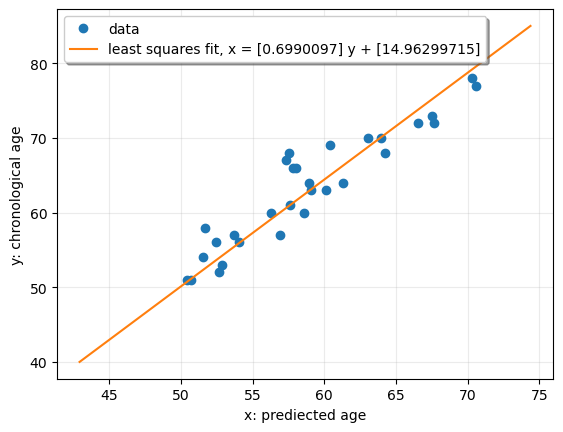

In [87]:
plot_bias_correction_result(MDD_pred_df["age_pred"].to_numpy(), MDD_pred_df["f.21003.2.0"].to_numpy(), slope, intercept)

### Save Results

In [88]:
MDD_pred_df.to_csv(f"./data/T1_MNI_20252_2_0/MDD_pred_age_{MDD_num}.csv")